<a href="https://colab.research.google.com/github/hideya1k/flask-medical-app/blob/main/notebook/train_yolov9_object_detection_on_custom_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Before you start

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [1]:
!nvidia-smi

Tue Mar 11 01:36:25 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   37C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

**NOTE:** To make it easier for us to manage datasets, images and models we create a `HOME` constant.

In [2]:
import os
HOME = os.getcwd()
print(HOME)

/content


## Clone and Install

**NOTE:** YOLOv9 is very new. At the moment, we recommend using a fork of the main repository. The `detect.py` script contains a bug that prevents inference. This bug is patched in the fork.

In [3]:
!git clone https://github.com/noorkhokhar99/yolov9.git
%cd yolov9
!pip install -r requirements.txt -q

Cloning into 'yolov9'...
remote: Enumerating objects: 165, done.
remote: Total 165 (delta 0), reused 0 (delta 0), pack-reused 165 (from 1)
Receiving objects: 100% (165/165), 628.69 KiB | 1.69 MiB/s, done.
Resolving deltas: 100% (65/65), done.
/content/yolov9
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 94.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 70.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 50.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━

**NOTE:** Let's install additional packages that will be useful later on.

In [4]:
!pip install -q roboflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.3/83.3 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 13.5 MB/s eta 0:00:00


## Imports

In [5]:
import roboflow

from IPython.display import Image

## Download model weights

**NOTE:** In the YOLOv9 paper, versions yolov9-s and yolov9-m are also mentioned, but the weights for these models are not yet available in the YOLOv9 repository.

In [6]:
!mkdir -p {HOME}/weights

In [7]:
!wget -P {HOME}/weights -q https://github.com/WongKinYiu/yolov9/releases/download/v0.1/yolov9-c.pt
!wget -P {HOME}/weights -q https://github.com/WongKinYiu/yolov9/releases/download/v0.1/yolov9-e.pt
!wget -P {HOME}/weights -q https://github.com/WongKinYiu/yolov9/releases/download/v0.1/gelan-c.pt
!wget -P {HOME}/weights -q https://github.com/WongKinYiu/yolov9/releases/download/v0.1/gelan-e.pt

In [9]:
!ls -la {HOME}/weights

total 402440
drwxr-xr-x 2 root root      4096 Mar 11 01:40 .
drwxr-xr-x 1 root root      4096 Mar 11 01:40 ..
-rw-r--r-- 1 root root  51508261 Feb 18  2024 gelan-c.pt
-rw-r--r-- 1 root root 117203713 Feb 18  2024 gelan-e.pt
-rw-r--r-- 1 root root 103153312 Feb 18  2024 yolov9-c.pt
-rw-r--r-- 1 root root 140217688 Feb 18  2024 yolov9-e.pt


## Download example data

In [10]:
!mkdir -p {HOME}/data

In [12]:
!wget -P {HOME}/data -q https://github.com/noorkhokhar99/yolov9-real-time-webcam/blob/main/dmeo.png

In [13]:
SOURCE_IMAGE_PATH = f"{HOME}/data/dmeo.png"

**NOTE:** If you want to run inference using your own file as input, simply upload image to Google Colab and update `SOURCE_IMAGE_PATH` with the path leading to your file.

## Detection with pre-trained COCO model

### gelan-c

In [36]:
!python detect.py --weights {HOME}/weights/gelan-c.pt --conf 0.1 --source {HOME}/data/dmeo.png --device 0

detect: weights=['/content/weights/gelan-c.pt'], source=/content/data/dmeo.png, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.1, iou_thres=0.45, max_det=1000, device=0, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v0.1-8-ga1c02c4 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)

/content/yolov9/models/experimental.py:75: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weigh

**NOTE:** By default, the results of each subsequent inference sessions are saved in `{HOME}/yolov9/runs/detect/`, in directories named `exp`, `exp2`, `exp3`, ... You can override this behavior by using the `--name` parameter.

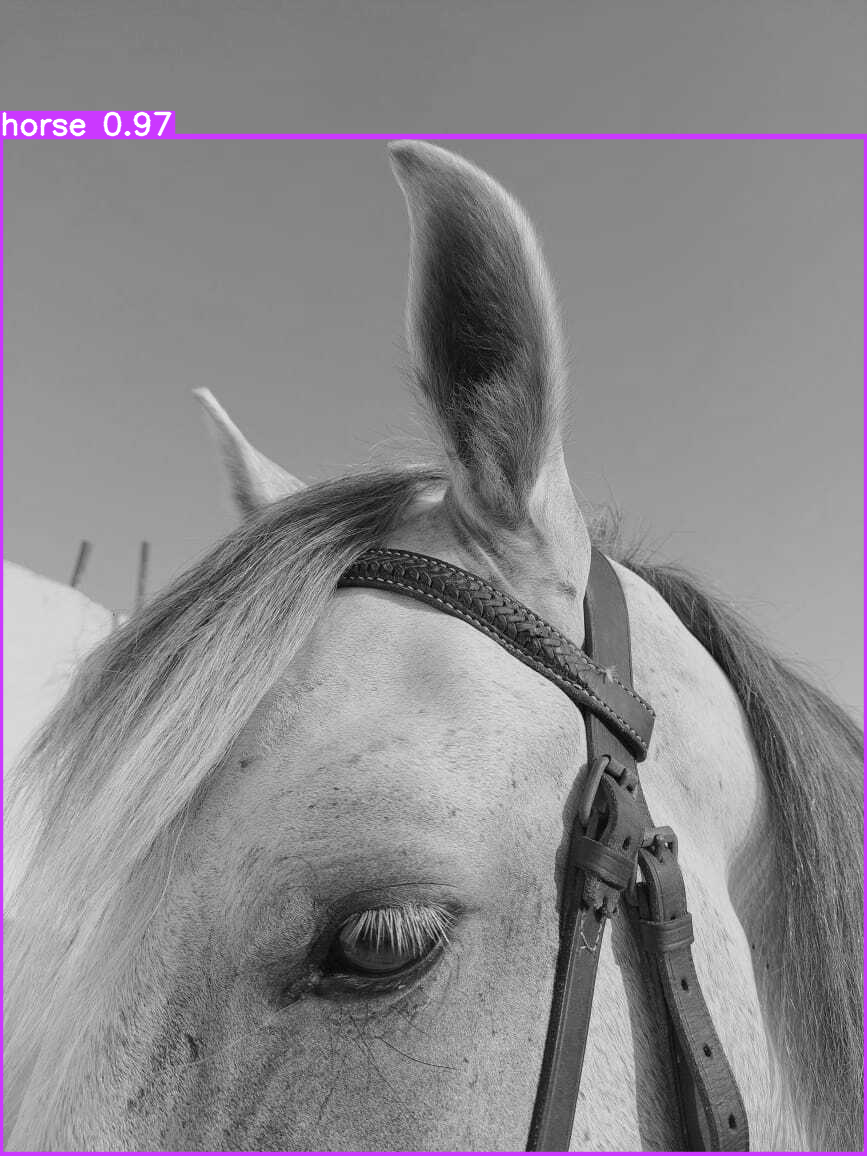

In [37]:
Image(filename=f"{HOME}/yolov9/runs/detect/exp13/dmeo.png", width=600)

## yolov9-e

## Authenticate and Download the Dataset

**NOTE:** The dataset must be saved inside the `{HOME}/yolov9` directory, otherwise, the training will not succeed.

In [49]:
%cd {HOME}/yolov9



!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="D9DHeokVtdDdonjemBC4")
project = rf.workspace("pest-g428a").project("fire-and-smoke-segmentation-d1z17")
version = project.version(1)
dataset = version.download("yolov9")









/content/yolov9
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Fire-and-Smoke-Segmentation-1 in yolov9:: 100%|██████████| 414/414 [00:00<00:00, 9796.35it/s]


In [55]:
yaml_path = "/content/yolov9/Fire-and-Smoke-Segmentation-1/data.yaml"

new_yaml_content = """names:
- fire
- smoke
nc: 2
roboflow:
  license: CC BY 4.0
  project: fire-and-smoke-segmentation-d1z17
  url: https://universe.roboflow.com/pest-g428a/fire-and-smoke-segmentation-d1z17/dataset/1
  version: 1
  workspace: pest-g428a
test: /content/yolov9/Fire-and-Smoke-Segmentation-1/test/images
train: /content/yolov9/Fire-and-Smoke-Segmentation-1/train/images
val: /content/yolov9/Fire-and-Smoke-Segmentation-1/valid/images
"""

with open(yaml_path, "w") as f:
    f.write(new_yaml_content)

print("✅ data.yaml updated successfully!")


✅ data.yaml updated successfully!


In [56]:
with open(yaml_path, "r") as f:
    print(f.read())


names:
- fire
- smoke
nc: 2
roboflow:
  license: CC BY 4.0
  project: fire-and-smoke-segmentation-d1z17
  url: https://universe.roboflow.com/pest-g428a/fire-and-smoke-segmentation-d1z17/dataset/1
  version: 1
  workspace: pest-g428a
test: /content/yolov9/Fire-and-Smoke-Segmentation-1/test/images
train: /content/yolov9/Fire-and-Smoke-Segmentation-1/train/images
val: /content/yolov9/Fire-and-Smoke-Segmentation-1/valid/images



## Train Custom Model

In [57]:
%cd {HOME}/yolov9

!python train.py \
--batch 16 --epochs 10 --img 400 --device 0 --min-items 0 --close-mosaic 15 \
--data {dataset.location}/data.yaml \
--weights {HOME}/weights/gelan-c.pt \
--cfg models/detect/gelan-c.yaml \
--hyp hyp.scratch-high.yaml



/content/yolov9
2025-03-11 02:32:14.263763: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741660334.286054   15333 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741660334.292713   15333 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-11 02:32:14.316889: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information

## Examine Training Results

**NOTE:** By default, the results of each subsequent training sessions are saved in `{HOME}/yolov9/runs/train/`, in directories named `exp`, `exp2`, `exp3`, ... You can override this behavior by using the `--name` parameter.

In [58]:
!ls {HOME}/yolov9/runs/train/exp

events.out.tfevents.1741659064.68f7202575c3.9457.0  hyp.yaml  opt.yaml	weights


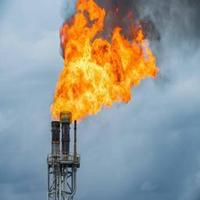

In [62]:
Image(filename=f"{HOME}/yolov9/runs/train/exp/thumbb.jpg", width=1000)

## Validate Custom Model

In [65]:
%cd {HOME}/yolov9

!python val.py \
--img 640 --batch 32 --conf 0.001 --iou 0.7 --device 0 \
--data {dataset.location}/data.yaml \
--weights {HOME}/yolov9/runs/train/exp/weights/gelan-c.pt

/content/yolov9
val: data=/content/yolov9/Fire-and-Smoke-Segmentation-1/data.yaml, weights=['/content/yolov9/runs/train/exp/weights/gelan-c.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.7, max_det=300, task=val, device=0, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False, min_items=0
YOLOv5 🚀 v0.1-8-ga1c02c4 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)

/content/yolov9/models/experimental.py:75: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `T

## Inference with Custom Model

In [ ]:
!python detect.py \
--img 1280 --conf 0.1 --device 0 \
--weights {HOME}/yolov9/runs/train/exp3/weights/best.pt \
--source {dataset.location}/valid/images

detect: weights=['/content/yolov9/runs/train/exp3/weights/best.pt'], source=/content/yolov9/crime-detection-1/valid/images, data=data/coco128.yaml, imgsz=[1280, 1280], conf_thres=0.1, iou_thres=0.45, max_det=1000, device=0, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v0.1-8-ga1c02c4 Python-3.10.12 torch-2.4.0+cu121 CUDA:0 (Tesla T4, 15102MiB)

/content/yolov9/models/experimental.py:75: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In 

In [ ]:
import glob
from IPython.display import Image, display

for image_path in glob.glob(f'{HOME}/yolov9/runs/detect/exp5/*.jpg')[:4]:
      display(Image(filename=image_path, width=600))
      print("\n")